In [3]:
%pylab inline
import numpy as np

import networkx as nx
from utility import ER_GNP, make_SBM, uniform_weight_edges
from sis import simulate_SIS, get_p_curve, get_p_curves, make_raster_plots
import importlib
from manage import (
    rank_by_evec,
    decrease_nodes_weights,
    decrease_top_nodes_weights,
    manage_nodes,
)

Populating the interactive namespace from numpy and matplotlib


# 1. Make Network to Study

In [4]:
np.random.seed(111)

In [53]:
K = 4 # number communities

def get_community(comm_type):
    if comm_type == "line":
        PI = 1/2*np.array([[.1,.05,.00,.00],
                          [.05,.1,.05,.00],
                          [.00,.05,.1,.05],
                          [.00,.00,.05,.1]])
    if comm_type == "star":
        PI = 1/2*np.array([[.1,.05,.05,.05],
                          [.05,.1,.00,.00],
                          [.05,.00,.1,.00],
                          [.05,.00,.00,.1]])
    if comm_type == "square":
        PI = 1/2*np.array([[.1,.05,.00,.05],
                          [.05,.1,.05,.00],
                          [.00,.05,.1,.05],
                          [.05,.00,.05,.1]])
    if comm_type == "closed":
        PI = 1/2*np.array([[.1,.05,.05,.05],
                          [.05,.1,.05,.05],
                          [.05,.05,.1,.05],
                          [.05,.05,.05,.1]])
    return PI



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.27662309669332347
0.35072322276301593
0.3326885759309169
0.37773360153149765


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


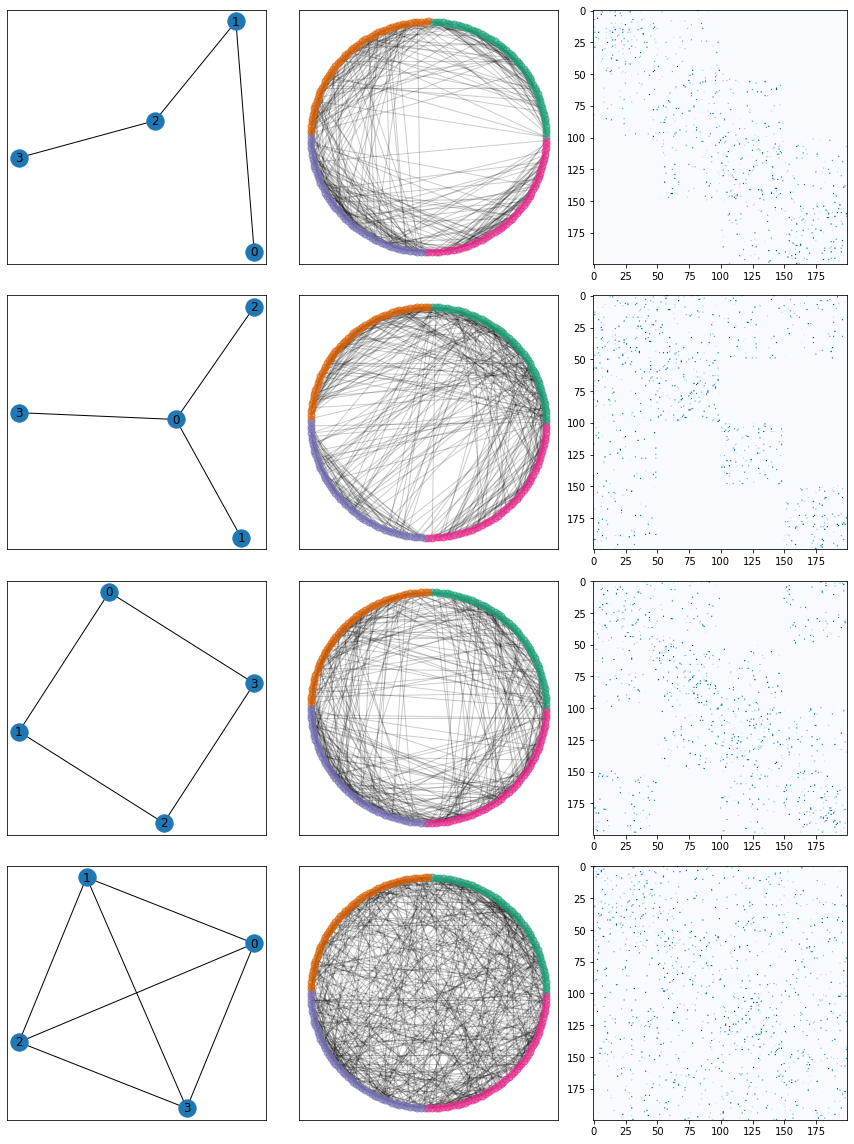

In [58]:
f1,ax = plt.subplots(4,3,figsize = (12,16))

for i, ct in enumerate(["line", "star", "square", "closed"]):
    PI = get_community(ct)
    N = 50*K # nodes
    Ns = np.ones(K,dtype=int)*N/K
    A,id_sets = make_SBM(Ns,PI)
    A = uniform_weight_edges(A,.1)
    lam = np.max(np.linalg.eigh(A)[0])
    print(lam)
   
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in range(K)]
    #colors = Pastel1#['b','r','g','y']
    P = nx.to_networkx_graph(PI, create_using=nx.Graph())
    nx.draw_networkx(P, ax=ax[i, 0])
    G = nx.to_networkx_graph(A,create_using=nx.Graph())
    pos = nx.circular_layout(G)
    for t,ids in enumerate(id_sets):
        nx.draw_networkx_nodes(G,pos,nodelist = ids,ax=ax[i, 1],node_size=50,node_color=colors[t],alpha=.6)
    nx.draw_networkx_edges(G,pos,ax=ax[i, 1],edge_size=2,node_color='k',alpha=.2)   

    temp = ax[i, 2].imshow(A,cmap='Blues')

#cbar = plt.colorbar(temp);
plt.tight_layout()
savefig('figs/community_net_plot.pdf')

In [5]:
# importlib.reload(manage_nodes)

In [6]:
p = 0.7
KK = 64
Ks = np.arange(0,KK,K)

rank_opts = {'type':'random' # rank completely at random
            }

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(A))] # global control

A_random,lams_random, Ksr = manage_nodes(A,rank_opts,manage_opts)

In [7]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':True, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'evec', # rank according to eigenvector centrality
            }
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(A))] # global control


manage_opts['online'] = True
AA,lams, Ks = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False
AA2,lams2, Ks2 = manage_nodes(A,rank_opts,manage_opts)


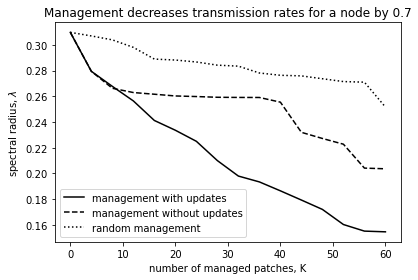

In [8]:
#plot(arange(K),lams[0]*np.ones(K),'k:')
plt.plot(Ks,lams,'k')
plt.plot(Ks2,lams2,'k--')
plt.plot(Ksr,lams_random,'k:')
plt.legend(['management with updates','management without updates','random management'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));
plt.tight_layout();
plt.savefig('figs/node_management_SBM222'+str(K)+'.pdf')

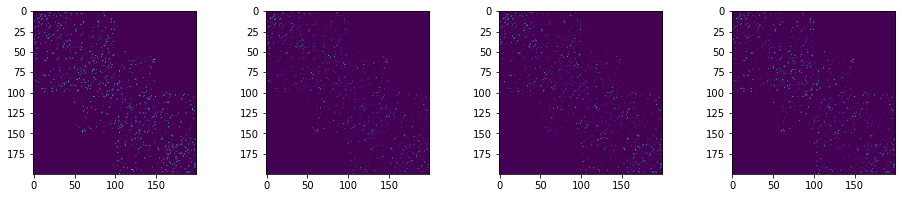

In [9]:
def make_scatters(ax,As):
    for t in range(len(As)):
        im = ax[t].imshow(As[t]);
        #plt.set_colorbar(im);
    return
        
f1,ax = plt.subplots(1,4,figsize=(16,3));
make_scatters(ax,[A,AA,AA2,A_random])

In [10]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'distributed':True # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'distributed_evec' # rank according to distributes eigenvector centrality
            }
b = int(ceil(KK / K))
rank_opts['budget'] = np.repeat(b, K)

# independent management
rank_opts['info_id_sets'] = [np.array(i) for i in id_sets]
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = True # update ranking after each modification? yes
AA3,lams3, Ks3 = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False # update ranking after each modification? no
AA4,lams4, Ks4 = manage_nodes(A,rank_opts,manage_opts)


# info sharing -- community minded folks
rank_opts['info_id_sets'] = [np.arange(len(A)) for i in id_sets] # global knowledge (and care)
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = True # update ranking after each modification? yes
AA5t,lams5t, Kst5 = manage_nodes(A,rank_opts,manage_opts)
AAt,lamst, Kst = manage_nodes(A,rank_opts,manage_opts)

manage_opts['online'] = False # update ranking after each modification? yes
AA6t,lams6t, Kst6 = manage_nodes(A,rank_opts,manage_opts)

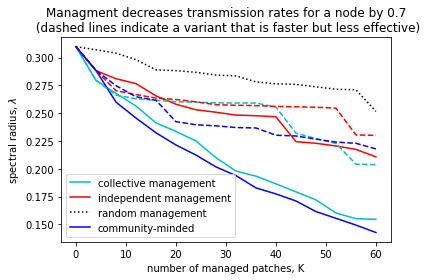

In [11]:
f1,ax = plt.subplots(1,1,figsize=(6,4));

plt.plot(Ks,lams,'c')
plt.plot(Ks3,lams3,'r')
plt.plot(Ksr,lams_random,'k:');
plt.plot(Kst5,lams5t,'b')
plt.legend(['collabrative management','independent management','random management', 'coordinated'])

plt.plot(Ks2,lams2,'c--')
plt.plot(Ks4,lams4,'r--');

plt.plot(Kst6,lams6t,'b--');

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Managment decreases transmission rates for a node by '+ str(manage_opts['p']) +'\n (dashed lines indicate a variant that is faster but less effective)');
plt.tight_layout();
plt.savefig('figs/node_management_SBM'+str(K)+'.pdf')

We compare characteristics of independent to coordinated management

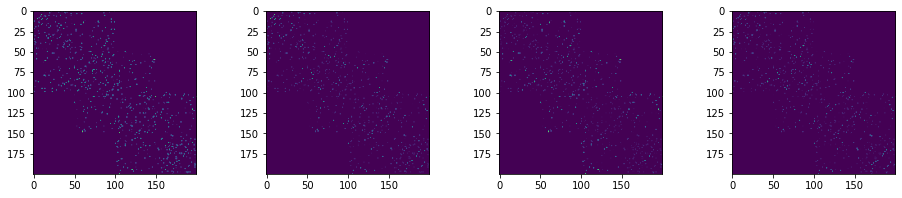

In [12]:
f1,ax = plt.subplots(1,4,figsize=(16,3));
# original A, AA collabrative, AA3 indep, AA5 comm minded (all 'online')
make_scatters(ax,[A, AA, AA3, AA5t])

## Examine change in distributional impact

we have the patch level probability of occupancy by a new outbreak (near threshold) as 
$p_i \approx \gamma * \lambda / \beta u_i$ with $\mathbf u$ right eigen vector of $A$. 

This gives us a way to look at expected total "damage": $\gamma \lambda /\beta \sum_{i \in Manager} u_i$. We can compare this for globally-knowledgable/concerned manager vs locally-knowledgable/concerned. Note that because this is linear in $\gamma\lambda/\beta$ the _relative_ total damage among managers is given just by the sums of the eigenvalue entries.

In [13]:
def dist_impact(A):
    l, u = np.linalg.eigh(A)
    l_max_idx = np.argmax(l) # should be the last one at position len(l)-1
    u_max = u[:, l_max_idx]
    return [sum(u_max[i]) for i in id_sets] / sum(u_max)

id_sets

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),
 array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 19

The **distribution of total damage across scenarios** for management strategies:



In [14]:
import pandas as pd  # for formatting


data = [dist_impact(AA6t),
        dist_impact(AA2),
        dist_impact(AA4),
        dist_impact(AA5t),
        dist_impact(AA),
        dist_impact(AA3)
       ]
df = pd.DataFrame(data, columns=["mgr 1", "mgr 2", "mgr 3", "mgr 4"], 
            index=["non-online", "non-online", "non-online", "online", "online", "online"])
df['strategy'] = [
    "cooperative",
    "collabrative planned",
    "independent",
       "coordinated",
    "collabrative coordinated",
    "independent"
]
df[['strategy', 'mgr 1', 'mgr 2', 'mgr 3', 'mgr 4']].round(2)

,strategy,mgr 1,mgr 2,mgr 3,mgr 4
non-online,globally-informed community-minded,0.07,0.34,0.30,0.29
non-online,collective,0.04,0.11,0.27,0.58
non-online,independent,0.25,0.35,0.28,0.13
online,globally-informed community-minded,0.22,0.33,0.22,0.23
online,collective,0.50,0.28,0.18,0.05
online,independent,0.15,0.39,0.24,0.22


The **change in percentage of damage incurred** when changing management strategies:



In [15]:
data = [dist_impact(AA6t)- dist_impact(AA4),
        dist_impact(AA6t)-dist_impact(AA2),
        dist_impact(AA2)-dist_impact(AA4),
        dist_impact(AA5t)-dist_impact(AA3),
        dist_impact(AA5t)-dist_impact(AA),
        dist_impact(AA)-dist_impact(AA3)
       ]

df = pd.DataFrame(data, columns=["mgr 1", "mgr 2", "mgr 3", "mgr 4"], 
            index=["non-online", "non-online", "non-online", "online", "online", "online"])
df['change in strategy'] = [
    "independent to cooperative",
    "collabrative to cooperative",
    "independent to collabrative",
       "independent to coordinated",
    "top-down to coordinated",
    "independent to collabrative"
]

df[['change in strategy', 'mgr 1', 'mgr 2', 'mgr 3', 'mgr 4']].round(2)

,change in strategy,mgr 1,mgr 2,mgr 3,mgr 4
non-online,independent to globally-informed community-minded,-0.18,-0.01,0.02,0.16
non-online,collective to globally-informed community-minded,0.03,0.23,0.03,-0.29
non-online,independent to collective,-0.21,-0.23,-0.02,0.46
online,independent to globally-informed community-minded,0.07,-0.06,-0.02,0.01
online,collective to globally-informed community-minded,-0.28,0.05,0.05,0.18
online,independent to collective,0.35,-0.11,-0.07,-0.17
